# %% [markdown]
# # ARIMA Forecasting - PM2.5 Time Series
# 
# **Notebook 3**: Build and evaluate ARIMA time series models

In [2]:
# ## 1. Import Libraries
import sys
sys.path.append(r"D:/Study/Mining/lab4/du-lieu-lon-khai-pha-du-lieu")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.timeseries_library import TimeSeriesAnalyzer, ARIMAModeler
import warnings
warnings.filterwarnings('ignore')

# Thiết lập style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
# ## 2. Configuration
# Thay đổi các tham số tại đây
STATION = 'Aotizhongxin'  # Chọn một trạm
CUTOFF_DATE = '2017-01-01'  # Chia train/test
FORECAST_HORIZON = 1  # One-step ahead forecasting

print("Configuration:")
print(f"- Station: {STATION}")
print(f"- Cutoff date: {CUTOFF_DATE}")
print(f"- Forecast horizon: {FORECAST_HORIZON}")

Configuration:
- Station: Aotizhongxin
- Cutoff date: 2017-01-01
- Forecast horizon: 1


In [4]:
# ### 3.1 Load cleaned data
print("Loading cleaned data...")
cleaned_df = pd.read_parquet('../data/processed/cleaned.parquet')
print(f"Data shape: {cleaned_df.shape}")

Loading cleaned data...
Data shape: (420768, 24)


In [5]:
# ### 3.2 Prepare time series
print(f"\nPreparing time series for station: {STATION}...")
analyzer = TimeSeriesAnalyzer()
ts_series = analyzer.prepare_time_series(cleaned_df, station=STATION)

# Hiển thị thông tin cơ bản
print(f"\nTime series info:")
print(f"- Length: {len(ts_series)}")
print(f"- Start: {ts_series.index.min()}")
print(f"- End: {ts_series.index.max()}")
print(f"- Missing values: {ts_series.isnull().sum()} ({ts_series.isnull().sum()/len(ts_series)*100:.2f}%)")

# Fill missing values (simple forward fill)
ts_series_filled = ts_series.ffill().bfill()
print(f"- After filling: {ts_series_filled.isnull().sum()} missing")


Preparing time series for station: Aotizhongxin...
Time series prepared
- Length: 35064
- Frequency: <Hour>
- Missing values: 925

Time series info:
- Length: 35064
- Start: 2013-03-01 00:00:00
- End: 2017-02-28 23:00:00
- Missing values: 925 (2.64%)
- After filling: 0 missing



Visualizing time series...


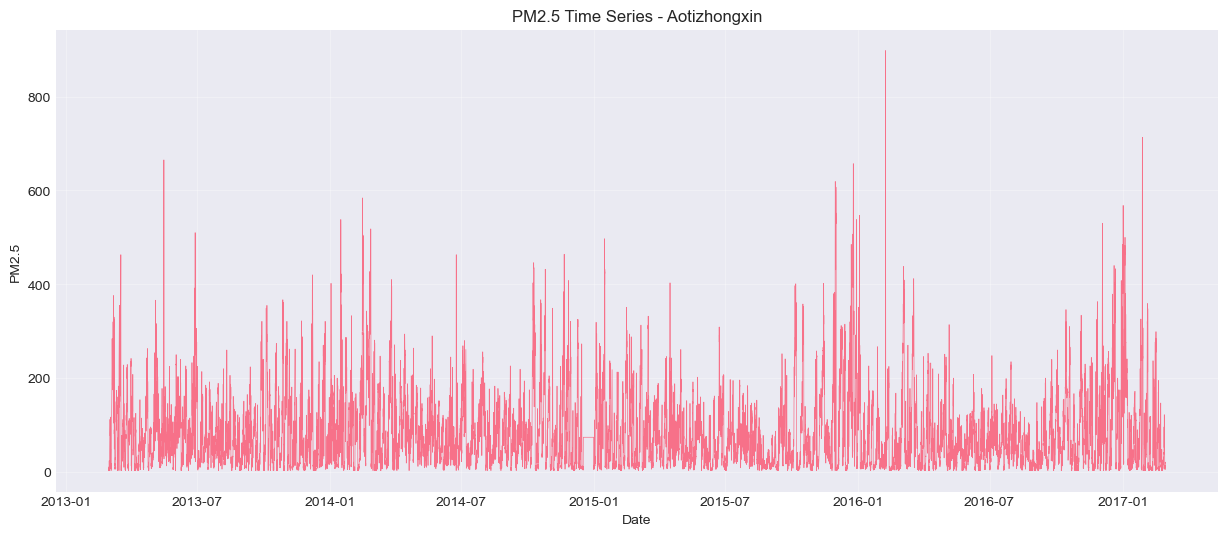

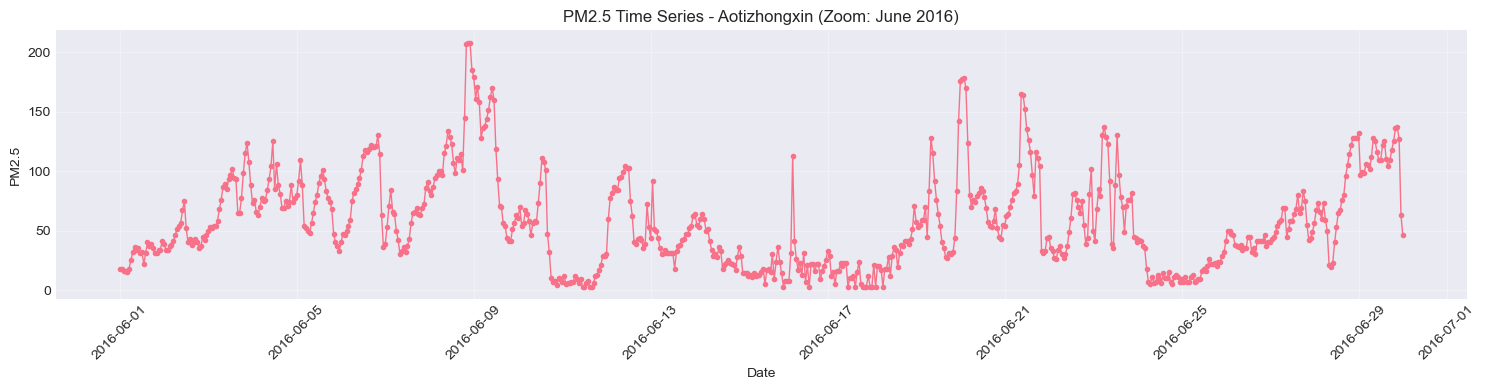

In [6]:
# ### 3.3 Visualize the time series
print("\nVisualizing time series...")

plt.figure(figsize=(15, 6))
plt.plot(ts_series_filled.index, ts_series_filled.values, linewidth=0.5)
plt.title(f'PM2.5 Time Series - {STATION}')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.grid(True, alpha=0.3)
plt.show()

# Zoom into specific period
zoom_start = '2016-06-01'
zoom_end = '2016-06-30'

zoom_mask = (ts_series_filled.index >= zoom_start) & (ts_series_filled.index <= zoom_end)
if zoom_mask.any():
    plt.figure(figsize=(15, 4))
    plt.plot(ts_series_filled[zoom_mask].index, ts_series_filled[zoom_mask].values, 
             marker='o', markersize=3, linewidth=1)
    plt.title(f'PM2.5 Time Series - {STATION} (Zoom: June 2016)')
    plt.xlabel('Date')
    plt.ylabel('PM2.5')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [7]:
# ### 4.1 Check stationarity of original series
print("\nChecking stationarity of original series...")
stationarity_results = analyzer.check_stationarity(ts_series_filled)

# Gợi ý d
d_recommended = stationarity_results['recommended_d']
print(f"\nRecommended differencing order (d): {d_recommended}")


Checking stationarity of original series...
Stationarity Test Results:
ADF test p-value: 0.0000 - Stationary
KPSS test p-value: 0.1000 - Stationary

Recommended differencing order (d): 0


In [8]:
# ### 4.2 Apply differencing if needed
if d_recommended > 0:
    print(f"\nApplying differencing (d={d_recommended})...")
    ts_diff = ts_series_filled.diff(d_recommended).dropna()
    
    # Check stationarity after differencing
    print("Checking stationarity after differencing...")
    analyzer.check_stationarity(ts_diff)
    
    # Visualize differenced series
    plt.figure(figsize=(15, 6))
    plt.plot(ts_diff.index, ts_diff.values, linewidth=0.5)
    plt.title(f'Differenced PM2.5 Time Series (d={d_recommended}) - {STATION}')
    plt.xlabel('Date')
    plt.ylabel(f'Δ^{d_recommended} PM2.5')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    ts_diff = ts_series_filled.copy()
    print("No differencing needed (series is stationary)")

No differencing needed (series is stationary)



Plotting ACF and PACF...


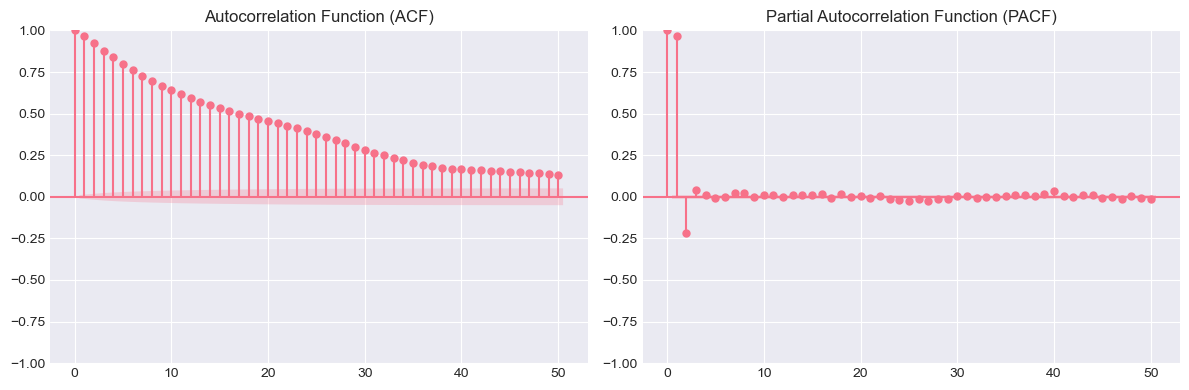

In [9]:
# ### 5.1 Plot ACF and PACF
print("\nPlotting ACF and PACF...")
analyzer.plot_acf_pacf(ts_diff, lags=50)


Suggesting ARIMA parameters from ACF/PACF...
ARIMA Parameter Suggestions:
p (AR order): 3
q (MA order): 1


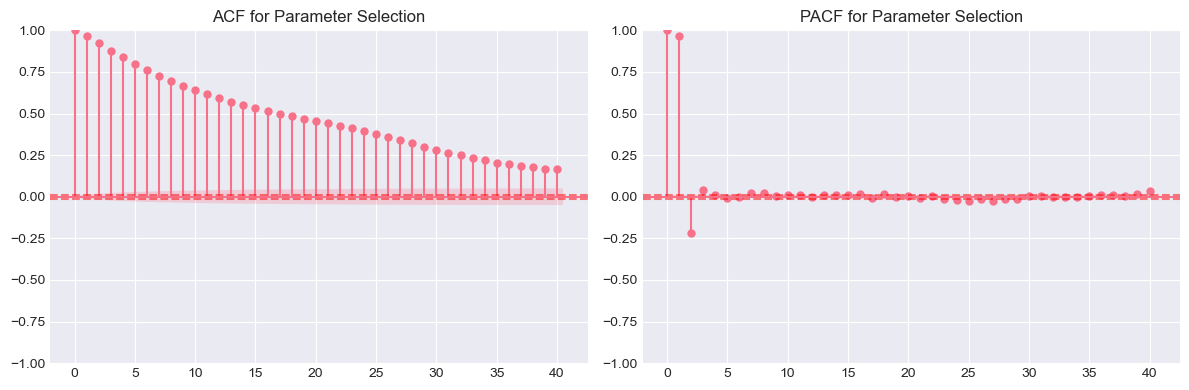

Suggested parameters from visual inspection:
- p (AR order): 3
- d (differencing): 0
- q (MA order): 1


In [10]:
# ### 5.2 Suggest ARIMA parameters
print("\nSuggesting ARIMA parameters from ACF/PACF...")
param_suggestions = analyzer.suggest_arima_params(ts_series_filled, d=d_recommended)

p_suggestion = param_suggestions['p_suggestion']
q_suggestion = param_suggestions['q_suggestion']

print(f"Suggested parameters from visual inspection:")
print(f"- p (AR order): {p_suggestion}")
print(f"- d (differencing): {d_recommended}")
print(f"- q (MA order): {q_suggestion}")


Splitting train/test at 2017-01-01...
Train size: 33648 (2013-03-01 00:00:00 to 2016-12-31 23:00:00)
Test size: 1416 (2017-01-01 00:00:00 to 2017-02-28 23:00:00)


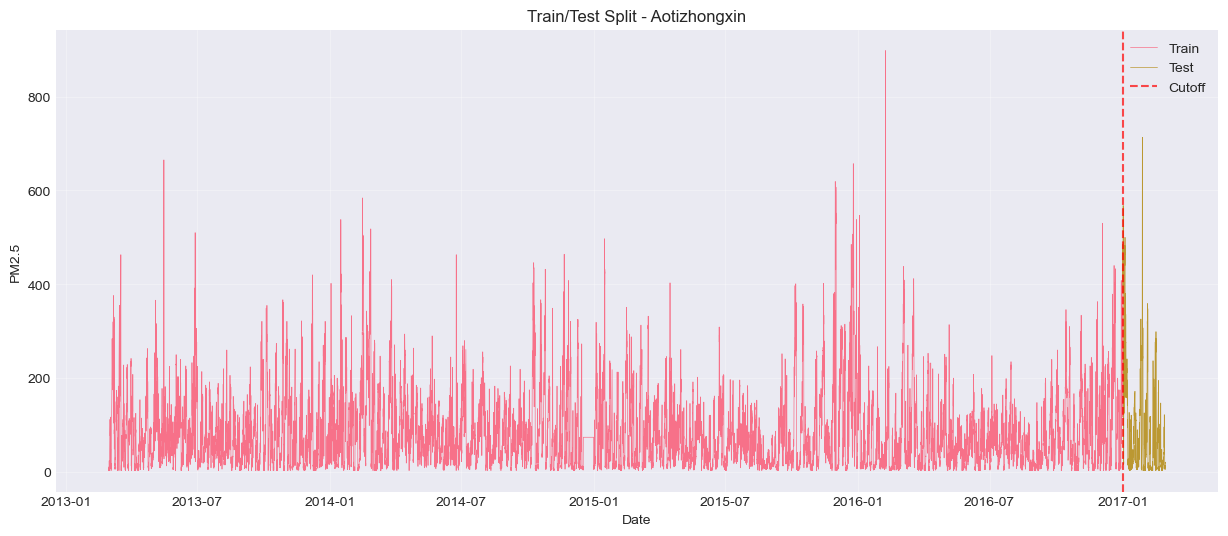

In [11]:
# ### 6.1 Split by time
print(f"\nSplitting train/test at {CUTOFF_DATE}...")

cutoff_datetime = pd.to_datetime(CUTOFF_DATE)
train_series = ts_series_filled[ts_series_filled.index < cutoff_datetime]
test_series = ts_series_filled[ts_series_filled.index >= cutoff_datetime]

print(f"Train size: {len(train_series)} ({train_series.index.min()} to {train_series.index.max()})")
print(f"Test size: {len(test_series)} ({test_series.index.min()} to {test_series.index.max()})")

# Visualize split
plt.figure(figsize=(15, 6))
plt.plot(train_series.index, train_series.values, label='Train', linewidth=0.5)
plt.plot(test_series.index, test_series.values, label='Test', linewidth=0.5)
plt.axvline(x=cutoff_datetime, color='red', linestyle='--', alpha=0.7, label='Cutoff')
plt.title(f'Train/Test Split - {STATION}')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
# ### 7.1 Grid Search for optimal parameters
print("\nPerforming grid search for ARIMA parameters...")

# Define search ranges
p_values = [0, 1, 2, 3]
d_values = [d_recommended]  # Use recommended d
q_values = [0, 1, 2, 3]

modeler = ARIMAModeler()
grid_results = modeler.grid_search_arima(
    train_series,
    p_values=p_values,
    d_values=d_values,
    q_values=q_values
)

# Display top 5 results
print("\nTop 5 ARIMA models by AIC:")
print(grid_results['all_results'].head(5))

# Get best parameters
best_order = grid_results['best_params']
best_model = grid_results['best_model']

print(f"\nBest ARIMA model: ARIMA{best_order}")
print(f"Best AIC: {grid_results['best_aic']:.2f}")


Performing grid search for ARIMA parameters...
Starting ARIMA grid search...
New best: ARIMA(0, 0, 0) - AIC: 390913.68, BIC: 390930.53
New best: ARIMA(0, 0, 1) - AIC: 353786.95, BIC: 353812.22
New best: ARIMA(0, 0, 2) - AIC: 331862.50, BIC: 331896.20
New best: ARIMA(0, 0, 3) - AIC: 319659.19, BIC: 319701.31
New best: ARIMA(1, 0, 0) - AIC: 298972.99, BIC: 298998.26
New best: ARIMA(1, 0, 1) - AIC: 297375.25, BIC: 297408.95
New best: ARIMA(1, 0, 2) - AIC: 297369.07, BIC: 297411.19
New best: ARIMA(1, 0, 3) - AIC: 297362.91, BIC: 297413.45
New best: ARIMA(3, 0, 1) - AIC: 297362.41, BIC: 297412.95

Grid search completed. Best model: ARIMA(3, 0, 1)
Best AIC: 297362.41, Best BIC: 297412.95

Top 5 ARIMA models by AIC:
   p  d  q            AIC            BIC
0  3  0  1  297362.412614  297412.954867
1  1  0  3  297362.907881  297413.450134
2  3  0  2  297363.594433  297422.560395
3  3  0  0  297363.698529  297405.817074
4  2  0  3  297363.846650  297422.812612

Best ARIMA model: ARIMA(3, 0, 1)


In [13]:
# ### 7.2 Train final ARIMA model
print(f"\nTraining final ARIMA{best_order} model...")
final_model = modeler.train_arima(train_series, order=best_order)


Training final ARIMA(3, 0, 1) model...
ARIMA(3, 0, 1) model trained
                               SARIMAX Results                                
Dep. Variable:                  pm2.5   No. Observations:                33648
Model:                 ARIMA(3, 0, 1)   Log Likelihood             -148675.206
Date:                Thu, 08 Jan 2026   AIC                         297362.413
Time:                        04:05:33   BIC                         297412.955
Sample:                    03-01-2013   HQIC                        297378.542
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.6977      3.927     21.061      0.000      75.002      90.394
ar.L1          1.4141      0.035     40.294      0.000       1

In [14]:
# ### 8.1 Make forecasts
print(f"\nMaking forecasts on test set...")
forecasts = modeler.forecast_arima(
    final_model,
    test_series,
    steps_ahead=FORECAST_HORIZON
)


Making forecasts on test set...


In [15]:
# ### 8.2 Evaluate forecasts
print("Evaluating forecasts...")
evaluation_results = modeler.evaluate_forecast(test_series, forecasts)

print("\nARIMA Model Performance:")
print(f"- MAE: {evaluation_results['MAE']:.2f}")
print(f"- RMSE: {evaluation_results['RMSE']:.2f}")
print(f"- MAPE: {evaluation_results['MAPE']:.2f}%")

Evaluating forecasts...

ARIMA Model Performance:
- MAE: 77.88
- RMSE: 104.04
- MAPE: 371.20%



Visualizing forecasts vs actual...


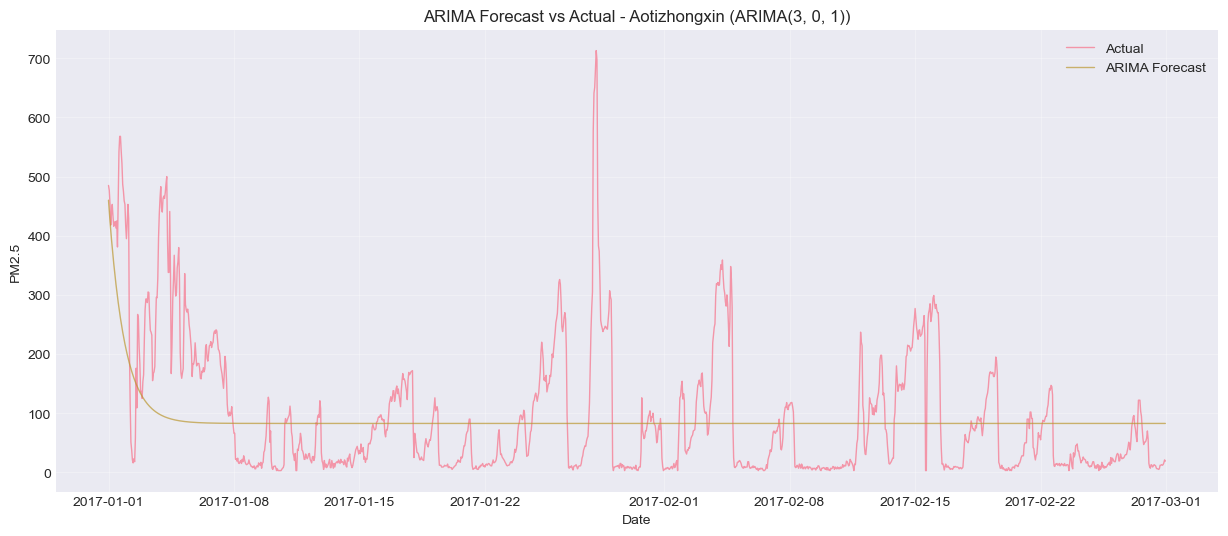

In [16]:
# ### 9.1 Plot forecasts vs actual
print("\nVisualizing forecasts vs actual...")

# Create results DataFrame
results_df = pd.DataFrame({
    'actual': test_series,
    'forecast': evaluation_results['forecast']
})

# Plot entire test period
plt.figure(figsize=(15, 6))
plt.plot(results_df.index, results_df['actual'], label='Actual', alpha=0.7, linewidth=1)
plt.plot(results_df.index, results_df['forecast'], label='ARIMA Forecast', alpha=0.7, linewidth=1)
plt.title(f'ARIMA Forecast vs Actual - {STATION} (ARIMA{best_order})')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Zooming into first month of test period...


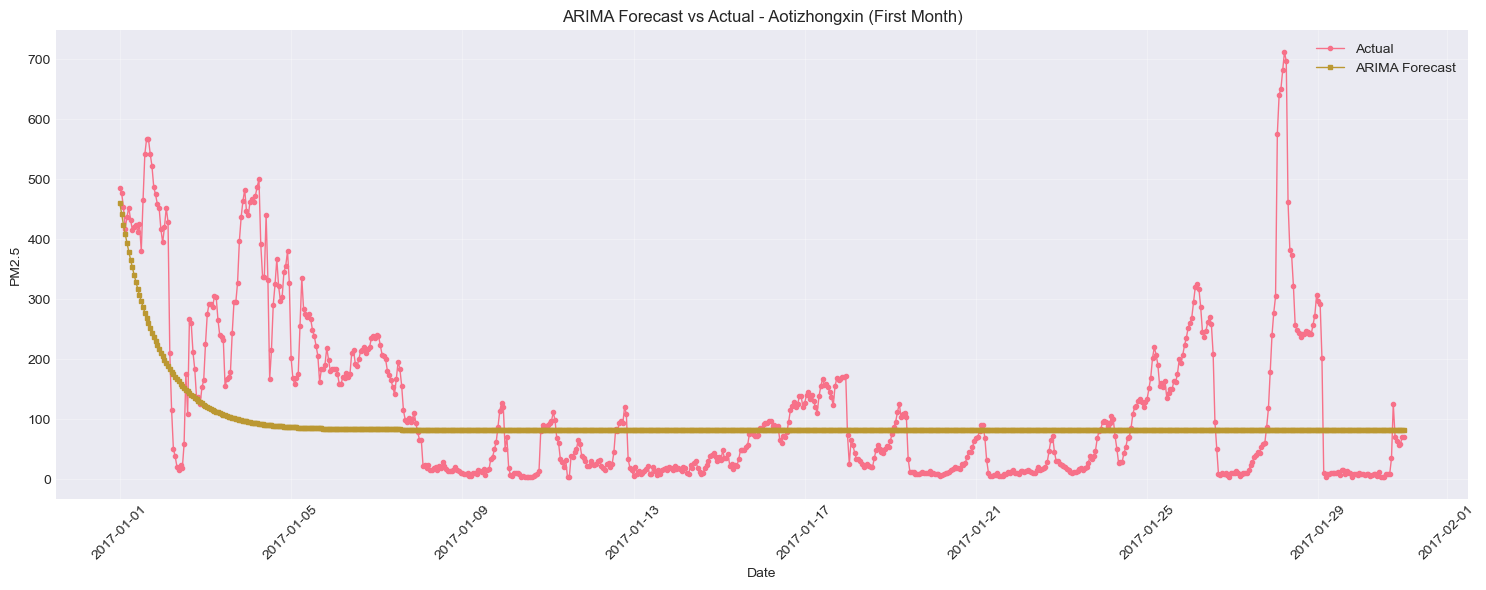

In [17]:
# ### 9.2 Zoom into specific period
print("\nZooming into first month of test period...")

zoom_start = results_df.index[0]
zoom_end = results_df.index[min(24*30, len(results_df)-1)]  # 30 days

zoom_results = results_df.loc[zoom_start:zoom_end]

plt.figure(figsize=(15, 6))
plt.plot(zoom_results.index, zoom_results['actual'], 
         label='Actual', marker='o', markersize=3, linewidth=1)
plt.plot(zoom_results.index, zoom_results['forecast'], 
         label='ARIMA Forecast', marker='s', markersize=3, linewidth=1)
plt.title(f'ARIMA Forecast vs Actual - {STATION} (First Month)')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Scatter plot: Actual vs Forecast...


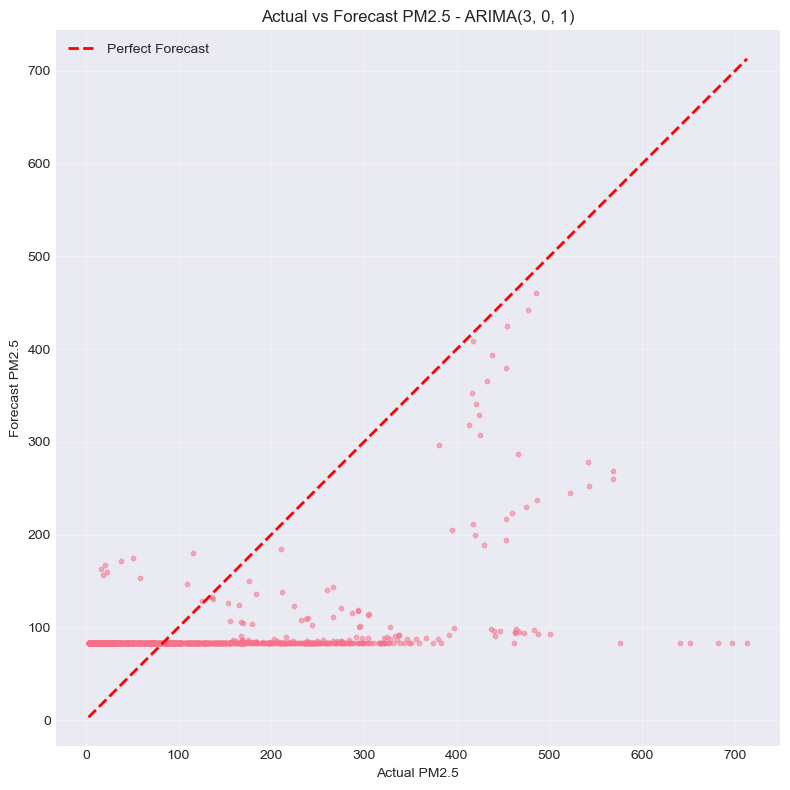

In [18]:
# ### 9.3 Scatter plot: Actual vs Forecast
print("\nScatter plot: Actual vs Forecast...")

plt.figure(figsize=(8, 8))
plt.scatter(results_df['actual'], results_df['forecast'], alpha=0.5, s=10)
plt.plot([results_df['actual'].min(), results_df['actual'].max()],
         [results_df['actual'].min(), results_df['actual'].max()],
         'r--', label='Perfect Forecast', linewidth=2)

plt.xlabel('Actual PM2.5')
plt.ylabel('Forecast PM2.5')
plt.title(f'Actual vs Forecast PM2.5 - ARIMA{best_order}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()


Analyzing forecast errors...


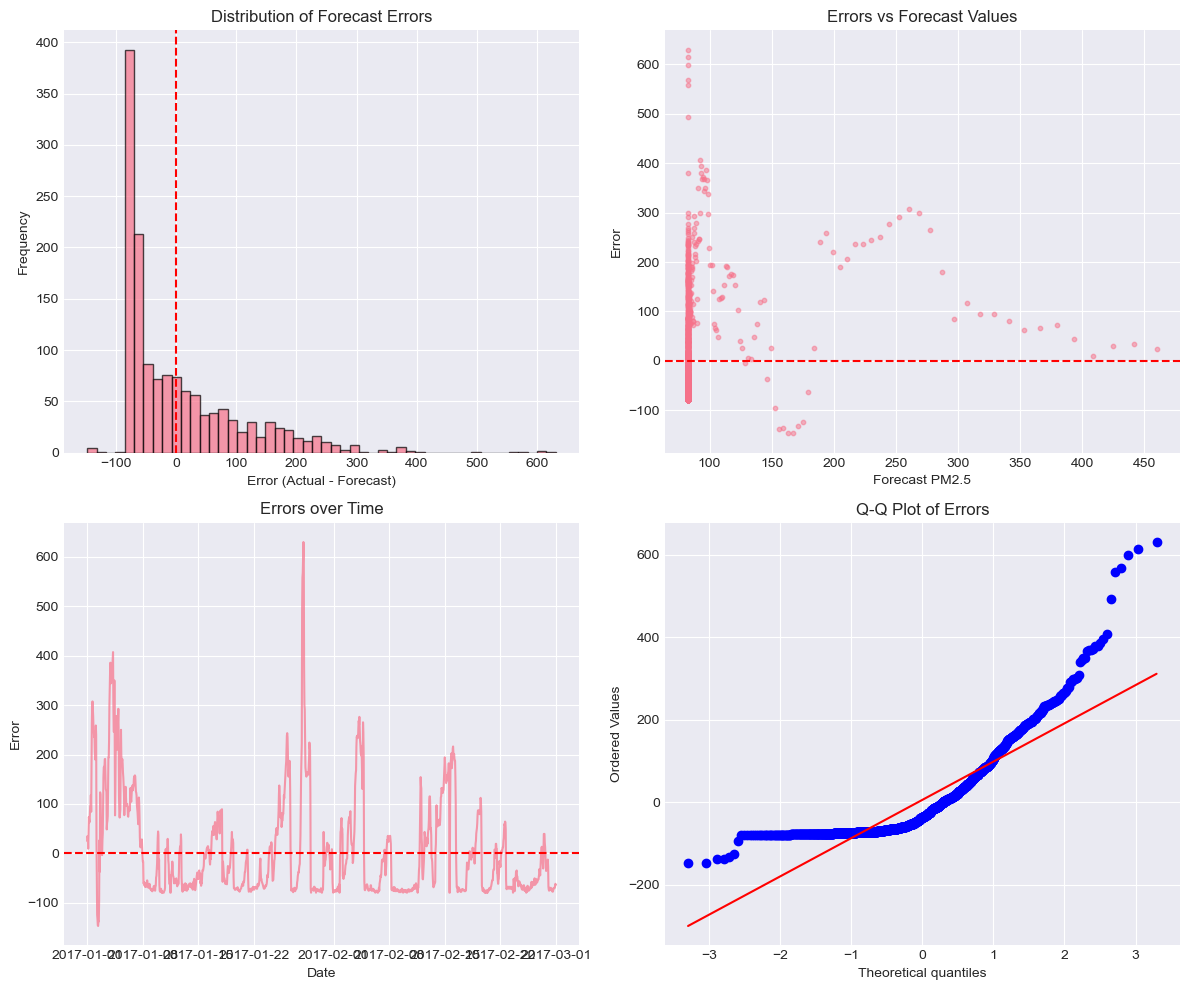


Error Statistics:
- Mean error: 5.87
- Std of errors: 103.91
- Min error: -147.11
- Max error: 630.30
- Mean absolute error: 77.88


In [19]:
# ### 9.4 Error analysis
print("\nAnalyzing forecast errors...")

errors = results_df['actual'] - results_df['forecast']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram of errors
axes[0, 0].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(x=0, color='red', linestyle='--')
axes[0, 0].set_title('Distribution of Forecast Errors')
axes[0, 0].set_xlabel('Error (Actual - Forecast)')
axes[0, 0].set_ylabel('Frequency')

# Errors vs Forecast
axes[0, 1].scatter(results_df['forecast'], errors, alpha=0.5, s=10)
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_title('Errors vs Forecast Values')
axes[0, 1].set_xlabel('Forecast PM2.5')
axes[0, 1].set_ylabel('Error')

# Errors over time
axes[1, 0].plot(results_df.index, errors, alpha=0.7)
axes[1, 0].axhline(y=0, color='red', linestyle='--')
axes[1, 0].set_title('Errors over Time')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Error')

# Q-Q plot of errors
from scipy import stats
stats.probplot(errors, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot of Errors')

plt.tight_layout()
plt.show()

# Error statistics
print("\nError Statistics:")
print(f"- Mean error: {errors.mean():.2f}")
print(f"- Std of errors: {errors.std():.2f}")
print(f"- Min error: {errors.min():.2f}")
print(f"- Max error: {errors.max():.2f}")
print(f"- Mean absolute error: {np.mean(np.abs(errors)):.2f}")



Analyzing model residuals...


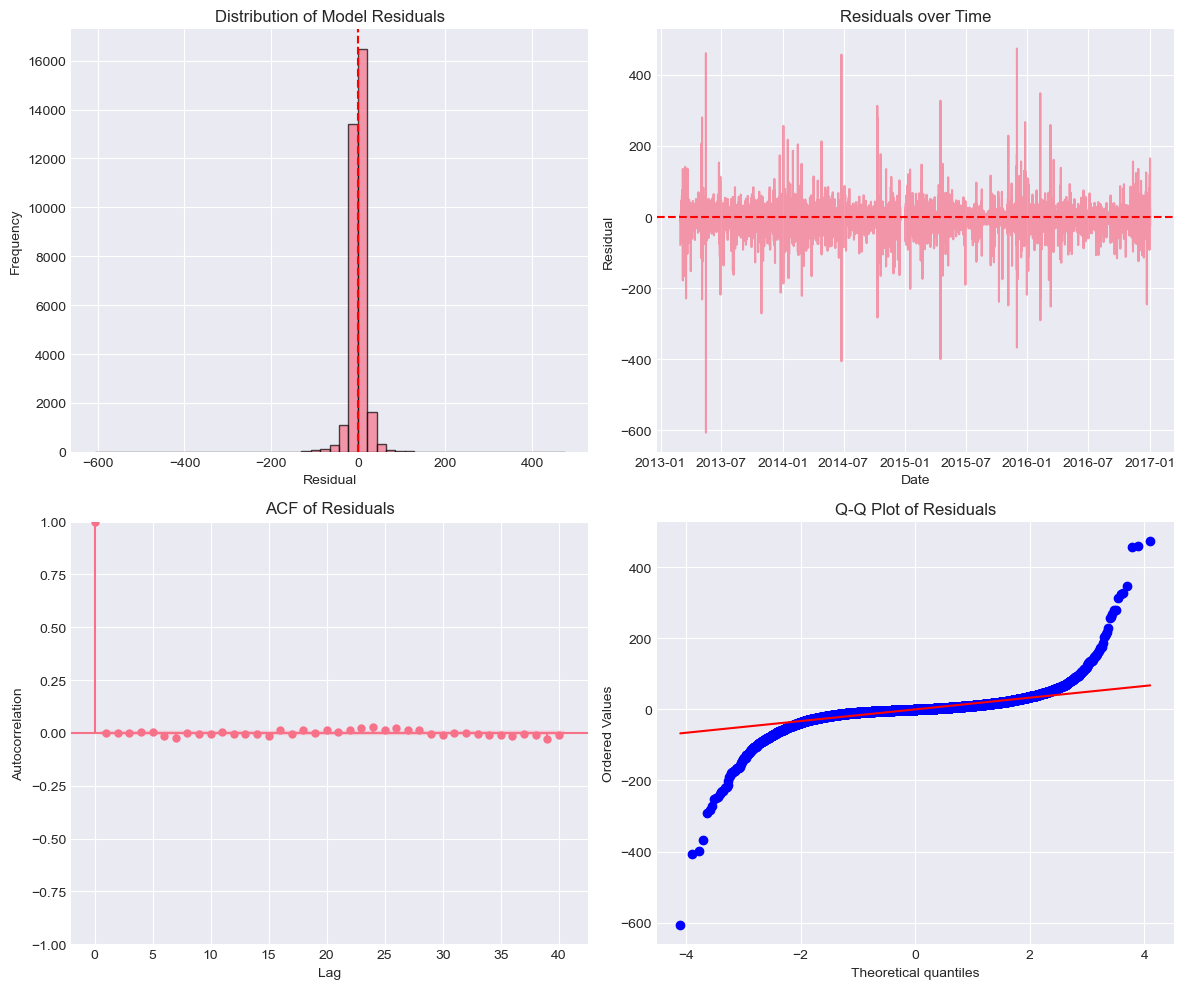

In [20]:
# ### 10.1 Residual analysis
print("\nAnalyzing model residuals...")

residuals = final_model.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram of residuals
axes[0, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(x=0, color='red', linestyle='--')
axes[0, 0].set_title('Distribution of Model Residuals')
axes[0, 0].set_xlabel('Residual')
axes[0, 0].set_ylabel('Frequency')

# Residuals over time
axes[0, 1].plot(residuals.index, residuals.values, alpha=0.7)
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_title('Residuals over Time')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Residual')

# ACF of residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals.dropna(), lags=40, ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title('ACF of Residuals')
axes[1, 0].set_xlabel('Lag')
axes[1, 0].set_ylabel('Autocorrelation')

# Q-Q plot of residuals
stats.probplot(residuals.dropna(), dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

In [21]:
# ### 10.2 Ljung-Box test for residual autocorrelation
print("\nPerforming Ljung-Box test for residual autocorrelation...")

from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(residuals.dropna(), lags=[10], return_df=True)
print(f"Ljung-Box test p-value: {lb_test['lb_pvalue'].values[0]:.4f}")

if lb_test['lb_pvalue'].values[0] > 0.05:
    print("✓ Residuals show no significant autocorrelation (GOOD)")
else:
    print("✗ Residuals show significant autocorrelation (model could be improved)")


Performing Ljung-Box test for residual autocorrelation...
Ljung-Box test p-value: 0.0006
✗ Residuals show significant autocorrelation (model could be improved)



Comparing with regression baseline...
Regression baseline found:
        station  horizon cutoff_date         best_model        mae       rmse  \
0  Aotizhongxin        1  2017-01-01  Linear Regression  12.206563  25.060414   

       mape       r2  num_features  
0  35.36763  0.99818            16  

Model Comparison:
                 Model        MAE        RMSE        MAPE
0  Regression Baseline  12.206563   25.060414   35.367630
1       ARIMA(3, 0, 1)  77.884754  104.038940  371.197983


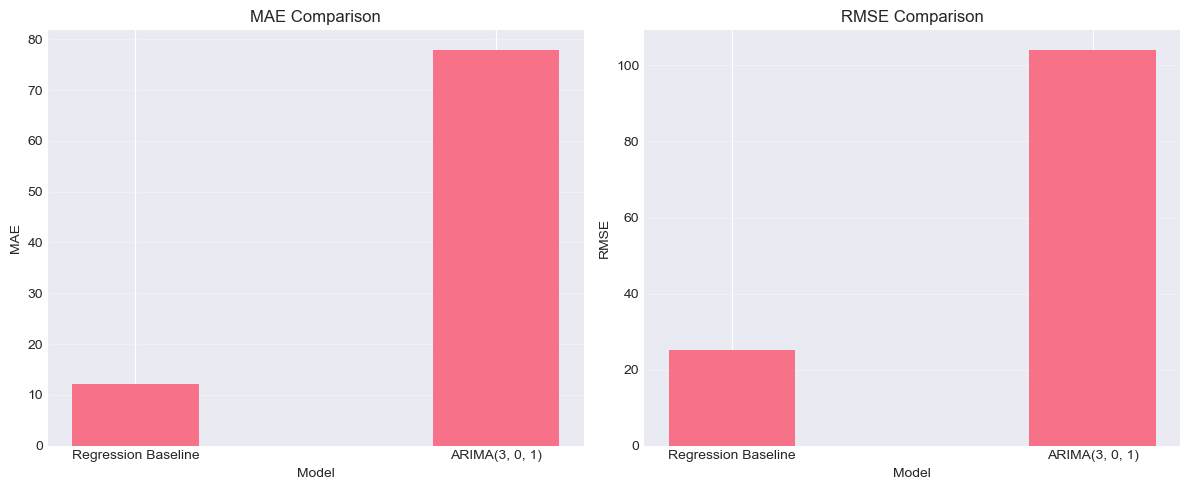


✓ Regression baseline is better by MAE
  ARIMA is 538.1% worse


In [22]:
# ### 11.1 Load regression results
print("\nComparing with regression baseline...")

try:
    # Try to load regression results
    regression_metrics_path = f'../data/processed/regression_metrics_{STATION}_h{FORECAST_HORIZON}.csv'
    regression_metrics = pd.read_csv(regression_metrics_path)
    
    print("Regression baseline found:")
    print(regression_metrics)
    
    # Create comparison table
    comparison_data = {
        'Model': ['Regression Baseline', f'ARIMA{best_order}'],
        'MAE': [regression_metrics['mae'].iloc[0], evaluation_results['MAE']],
        'RMSE': [regression_metrics['rmse'].iloc[0], evaluation_results['RMSE']],
        'MAPE': [regression_metrics['mape'].iloc[0], evaluation_results['MAPE']]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\nModel Comparison:")
    print(comparison_df)
    
    # Visual comparison
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    x = np.arange(len(comparison_df))
    width = 0.35
    
    # MAE comparison
    axes[0].bar(x, comparison_df['MAE'], width, label=['Regression', 'ARIMA'])
    axes[0].set_xlabel('Model')
    axes[0].set_ylabel('MAE')
    axes[0].set_title('MAE Comparison')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(comparison_df['Model'])
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # RMSE comparison
    axes[1].bar(x, comparison_df['RMSE'], width, label=['Regression', 'ARIMA'])
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel('RMSE')
    axes[1].set_title('RMSE Comparison')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(comparison_df['Model'])
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Determine which model is better
    if comparison_df.loc[0, 'MAE'] < comparison_df.loc[1, 'MAE']:
        print(f"\n✓ Regression baseline is better by MAE")
        improvement = ((comparison_df.loc[0, 'MAE'] - comparison_df.loc[1, 'MAE']) / 
                      comparison_df.loc[0, 'MAE']) * 100
        print(f"  ARIMA is {abs(improvement):.1f}% {'worse' if improvement < 0 else 'better'}")
    else:
        print(f"\n✓ ARIMA is better by MAE")
        improvement = ((comparison_df.loc[0, 'MAE'] - comparison_df.loc[1, 'MAE']) / 
                      comparison_df.loc[0, 'MAE']) * 100
        print(f"  ARIMA is {improvement:.1f}% better")
        
except FileNotFoundError:
    print("Regression baseline results not found. Run regression notebook first.")

In [23]:
# ## 12. Insights and Recommendations
print("\n" + "="*60)
print("INSIGHTS AND RECOMMENDATIONS")
print("="*60)

# Insight 1: Model performance
print("\n1. ARIMA MODEL PERFORMANCE:")
print(f"   - Best model: ARIMA{best_order}")
print(f"   - MAE: {evaluation_results['MAE']:.2f}")
print(f"   - AIC: {grid_results['best_aic']:.2f}")
print(f"   - Interpretation: Captures temporal dependencies well")

# Insight 2: Parameter interpretation
print("\n2. PARAMETER INTERPRETATION:")
print(f"   - d={best_order[1]}: Series needed {best_order[1]} differencing to be stationary")
print(f"   - p={best_order[0]}: Current value depends on {best_order[0]} previous values")
print(f"   - q={best_order[2]}: Current error depends on {best_order[2]} previous errors")

# Insight 3: Residual analysis
print("\n3. RESIDUAL ANALYSIS:")
print(f"   - Residual mean: {residuals.mean():.2f} (close to 0)")
print(f"   - Residual std: {residuals.std():.2f}")
if lb_test['lb_pvalue'].values[0] > 0.05:
    print(f"   - Residuals: White noise (GOOD)")
else:
    print(f"   - Residuals: Not white noise (model can be improved)")

# Insight 4: Strengths and weaknesses
print("\n4. STRENGTHS AND WEAKNESSES:")
print(f"   - Strengths: Captures autocorrelation, good for short-term forecasts")
print(f"   - Weaknesses: Assumes linear relationships, struggles with outliers")
print(f"   - Best for: Stationary or differenced stationary series")

# Insight 5: Practical recommendations
print("\n5. PRACTICAL RECOMMENDATIONS:")
print(f"   - Use for: 1-24 hour ahead forecasts")
print(f"   - Update frequency: Daily or weekly retraining")
print(f"   - Monitor: Residual patterns for model degradation")
print(f"   - Consider: SARIMA for seasonality, SARIMAX for exogenous variables")


INSIGHTS AND RECOMMENDATIONS

1. ARIMA MODEL PERFORMANCE:
   - Best model: ARIMA(3, 0, 1)
   - MAE: 77.88
   - AIC: 297362.41
   - Interpretation: Captures temporal dependencies well

2. PARAMETER INTERPRETATION:
   - d=0: Series needed 0 differencing to be stationary
   - p=3: Current value depends on 3 previous values
   - q=1: Current error depends on 1 previous errors

3. RESIDUAL ANALYSIS:
   - Residual mean: 0.01 (close to 0)
   - Residual std: 20.08
   - Residuals: Not white noise (model can be improved)

4. STRENGTHS AND WEAKNESSES:
   - Strengths: Captures autocorrelation, good for short-term forecasts
   - Weaknesses: Assumes linear relationships, struggles with outliers
   - Best for: Stationary or differenced stationary series

5. PRACTICAL RECOMMENDATIONS:
   - Use for: 1-24 hour ahead forecasts
   - Update frequency: Daily or weekly retraining
   - Monitor: Residual patterns for model degradation
   - Consider: SARIMA for seasonality, SARIMAX for exogenous variables


In [24]:
# ## 13. Save Results
print("\nSaving results...")

# Save forecasts
forecasts_df = pd.DataFrame({
    'datetime': results_df.index,
    'actual': results_df['actual'].values,
    'arima_forecast': results_df['forecast'].values,
    'error': errors.values
})

forecasts_path = f'../data/processed/arima_forecasts_{STATION}_h{FORECAST_HORIZON}.csv'
forecasts_df.to_csv(forecasts_path, index=False)
print(f"Forecasts saved to: {forecasts_path}")

# Save model summary
model_summary = {
    'station': STATION,
    'cutoff_date': CUTOFF_DATE,
    'horizon': FORECAST_HORIZON,
    'arima_order': str(best_order),
    'aic': grid_results['best_aic'],
    'bic': grid_results['best_bic'],
    'mae': evaluation_results['MAE'],
    'rmse': evaluation_results['RMSE'],
    'mape': evaluation_results['MAPE'],
    'residual_mean': residuals.mean(),
    'residual_std': residuals.std(),
    'ljung_box_pvalue': lb_test['lb_pvalue'].values[0],
    'training_period': f"{train_series.index.min()} to {train_series.index.max()}",
    'test_period': f"{test_series.index.min()} to {test_series.index.max()}"
}

summary_df = pd.DataFrame([model_summary])
summary_path = f'../data/processed/arima_summary_{STATION}_h{FORECAST_HORIZON}.csv'
summary_df.to_csv(summary_path, index=False)
print(f"Model summary saved to: {summary_path}")

# Save the model (optional)
import joblib
model_path = f'../data/processed/arima_model_{STATION}_h{FORECAST_HORIZON}.joblib'
joblib.dump(final_model, model_path)
print(f"Model saved to: {model_path}")


Saving results...
Forecasts saved to: ../data/processed/arima_forecasts_Aotizhongxin_h1.csv
Model summary saved to: ../data/processed/arima_summary_Aotizhongxin_h1.csv
Model saved to: ../data/processed/arima_model_Aotizhongxin_h1.joblib
